In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Q1

/home/vishwangi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


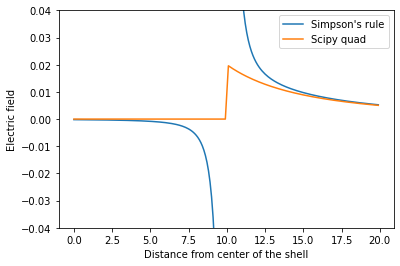

In [2]:
#Choosing the charge density such that the constant factor outside the integral is 1 
from scipy import integrate
R = 10
u = np.linspace(-1, 1, 100)
du = np.median(np.diff(u))
z = np.arange(0, 20, 0.1)
int_quad = np.zeros(len(z))
int_scipy = np.zeros(len(z))
for i in range(len(z)):
    fun = (z[i] - R*u)/(R**2 + z[i]**2 - 2*R*z[i]*u)**1.5
    int_quad[i] = du/3.0*(fun[0]+fun[-1]+4*np.sum(fun[1::2])+2*np.sum(fun[2:-1:2]))
    scipy_fun = lambda x: (z[i] - R*x)/(R**2 + z[i]**2 - 2*R*z[i]*x)**1.5
    int_scipy[i], error = integrate.quad(scipy_fun, -1, 1)
plt.plot(z, int_quad, label = "Simpson's rule")
plt.plot(z, int_scipy, label = "Scipy quad")
plt.xlabel("Distance from center of the shell")
plt.ylabel("Electric field")
plt.ylim(-0.04, 0.04)
plt.legend()

# Q2

In [3]:
def integrate_adaptive(fun,a,b,tol,extra=None):
    fun_count = 0
    x=np.linspace(a,b,5)
    dx=x[1]-x[0]
    if extra == None:
        y=fun(x)
        fun_count += len(x)
    else :
        y = [extra[0], fun(x[1]), extra[1], fun(x[3]), extra[2]]
        fun_count += 2
    #do the 3-point integral
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    myerr=np.abs(i1-i2)
    if myerr<tol:
        return i2,fun_count
    else:
        mid=(a+b)/2
        int1, count1=integrate_adaptive(fun,a,mid,tol/2, extra=[y[0], y[1], y[2]])
        int2, count2=integrate_adaptive(fun,mid,b,tol/2, extra=[y[2], y[3], y[4]])
        return int1+int2, count1+count2

In [7]:
def integrate_lazy(fun,a,b,tol):
    fun_count = 0
    x=np.linspace(a,b,5)
    dx=x[1]-x[0]
    y=fun(x)
    fun_count += len(x)
    #do the 3-point integral
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    myerr=np.abs(i1-i2)
    if myerr<tol:
        return i2, fun_count
    else:
        mid=(a+b)/2
        int1, count1 =integrate_lazy(fun,a,mid,tol/2)
        int2, count2 =integrate_lazy(fun,mid,b,tol/2)
        return int1+int2, count1+count2

In [9]:
# Integrating e^x from 0 to 2
from scipy import integrate
ans1, count1 = integrate_adaptive(np.exp, 0, 2, tol = 1e-6, extra=None)
ans2, count2 = integrate_lazy(np.exp, 0, 2, tol = 1e-6)
print("Integral = {} and # of function calls = {} for my function".format(ans1, count1))
print("Integral = {} and # of function calls = {} for the lazy function".format(ans2, count2))
print("Real integral value = {}".format(integrate.quad(np.exp, 0, 2)[0]))

Integral = 6.3890561284651 and # of function calls = 34 for my function
Integral = 6.3890561284651 and # of function calls = 85 for the lazy function
Real integral value = 6.3890560989306495


In [11]:
ans1, count1 = integrate_adaptive(np.log, 1, 10, tol = 1e-6, extra=None)
ans2, count2 = integrate_lazy(np.log, 1, 10, tol = 1e-6)
print("Integral = {} and # of function calls = {} for my function".format(ans1, count1))
print("Integral = {} and # of function calls = {} for the lazy function".format(ans2, count2))
print("Real integral value = {}".format(integrate.quad(np.log, 1, 10)[0]))

Integral = 14.025850907644363 and # of function calls = 76 for my function
Integral = 14.025850907644363 and # of function calls = 190 for the lazy function
Real integral value = 14.025850929940457


In [12]:
ans1, count1 = integrate_adaptive(np.sin, 0, np.pi, tol = 1e-6, extra=None)
ans2, count2 = integrate_lazy(np.sin, 0, np.pi, tol = 1e-6)
print("Integral = {} and # of function calls = {} for my function".format(ans1, count1))
print("Integral = {} and # of function calls = {} for the lazy function".format(ans2, count2))
print("Real integral value = {}".format(integrate.quad(np.sin, 0, np.pi)[0]))

Integral = 2.0000000217516316 and # of function calls = 48 for my function
Integral = 2.0000000217516316 and # of function calls = 120 for the lazy function
Real integral value = 2.0


# Q3

In [13]:
def cheby_model(x, y, tol, ord):
    len_x = len(x)
    x_min = x[0]
    x_max = x[len(x)-1]
    old_range = x_max - x_min
    new_range = 1 - (-1)
    new_x = (((x - x_min) * new_range) / old_range) + (-1)
    mat=np.zeros([len_x,ord+1])
    mat[:,0]=1.0
    if ord>0:
        mat[:,1]=new_x
    if ord>1:
        for i in range(1,ord):
            mat[:,i+1]=2*new_x*mat[:,i]-mat[:,i-1]
    coeff = np.polynomial.chebyshev.chebfit(new_x, y, ord)
    pred = np.dot(mat, coeff)
    error = np.abs(y-pred)
    max_error = np.max(error)
    while(max_error <= tol):
        ord = ord - 1
        mat = mat[:, 0:ord+1:1]
        coeff = coeff[0:ord+1:1]
        pred = np.dot(mat, coeff)
        error = np.abs(y-pred)
        max_error = np.max(error)
        rms_error = np.sqrt(np.mean((pred-y)**2))
    return pred, max_error, rms_error, ord+1, coeff

In [14]:
x = np.linspace(0.5, 1, 10000)
y = np.log2(x)
ord = 150
tol = pow(10, -7)
pred, max_error, rms_error, terms, coeff = cheby_model(x, y, tol, ord)
print("The number of terms needed to have a max error = {} and rms error = {} is {}".format(max_error, rms_error, terms))

The number of terms needed to have a max error = 3.196978304309539e-07 and rms error = 1.9185635134716262e-07 is 8


Text(0, 0.5, 'Predicted - Real value of log2(x)')

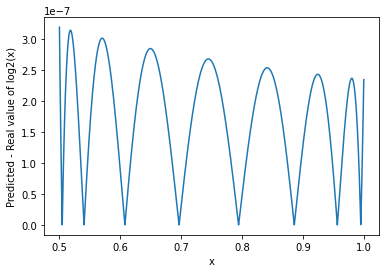

In [228]:
plt.plot(x, np.abs(y-pred))
plt.xlabel("x")
plt.ylabel("Predicted - Real value of log2(x)")

In [229]:
def mylog2(x, coeff):
    mant, exp = np.frexp(x)
    mant_new = (mant - 0.5)*(1 -(-1))/(1-0.5) + (-1)
    log2_x = np.polynomial.chebyshev.chebval(mant_new, coeff) + exp
    mant_e, exp_e = np.frexp(np.e)
    mant_e_new = (mant_e - 0.5)*(1 -(-1))/(1-0.5) + (-1)
    log2_e = np.polynomial.chebyshev.chebval(mant_e_new, coeff) + exp_e
    ln = log2_x/log2_e
    return ln

Max error = 8.768117671920095e-07 and RMS error = 6.324117839567934e-07 in the chebyshev fit for ln(x)


Text(0, 0.5, 'Predicted - Real value of ln(x)')

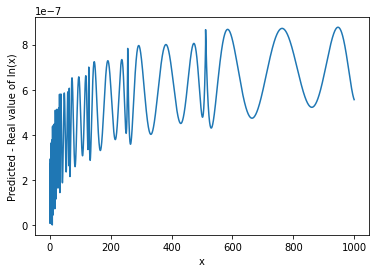

In [230]:
x = np.linspace(0.1, 1000, 10000)
ln_pred = mylog2(x, coeff)
ln = np.log(x)
max_error_ln = np.max(np.abs(ln_pred - ln))
rms_error_ln = np.sqrt(np.mean((ln_pred-ln)**2))
print("Max error = {} and RMS error = {} in the chebyshev fit for ln(x)".format(max_error_ln, rms_error_ln))
plt.plot(x, np.abs(ln_pred - ln))
plt.xlabel("x")
plt.ylabel("Predicted - Real value of ln(x)")

### Fitting with legendre

In [15]:
def legendre_model(x, y, ord):
    len_x = len(x)
    x_min = x[0]
    x_max = x[len(x)-1]
    old_range = x_max - x_min
    new_range = 1 - (-1)
    new_x = (((x - x_min) * new_range) / old_range) + (-1)
    c = np.polynomial.legendre.legfit(new_x, y, ord)
    return c

In [16]:
x = np.linspace(0.5, 1, 10000)
y = np.log2(x)
coeff_legendre = legendre_model(x, y, 8-1)

In [17]:
def mylog2_legendre(x, coeff):
    mant, exp = np.frexp(x)
    mant_new = (mant - 0.5)*(1 -(-1))/(1-0.5) + (-1)
    log2_x = np.polynomial.legendre.legval(mant_new, coeff) + exp
    mant_e, exp_e = np.frexp(np.e)
    mant_e_new = (mant_e - 0.5)*(1 -(-1))/(1-0.5) + (-1)
    log2_e = np.polynomial.legendre.legval(mant_e_new, coeff) + exp_e
    ln = log2_x/log2_e
    return ln

Max error = 1.1141421474292201e-06 and RMS error = 5.426786559419055e-07 in the legendre fit for ln(x)


Text(0, 0.5, 'Predicted - Real value of ln(x)')

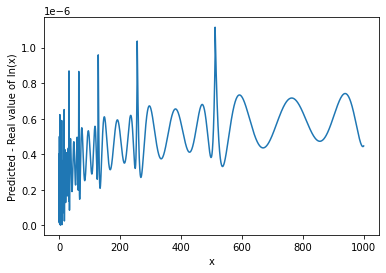

In [18]:
x = np.linspace(0.1, 1000, 10000)
ln_pred_leg = mylog2_legendre(x, coeff_legendre)
ln = np.log(x)
max_error_ln_leg = np.max(np.abs(ln_pred_leg - ln))
rms_error_ln_leg = np.sqrt(np.mean((ln_pred_leg-ln)**2))
print("Max error = {} and RMS error = {} in the legendre fit for ln(x)".format(max_error_ln_leg, rms_error_ln_leg))
plt.plot(x, np.abs(ln_pred_leg - ln))
plt.xlabel("x")
plt.ylabel("Predicted - Real value of ln(x)")